In [59]:
# Importações

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from src.config import DADOS_TRATADOS
from src.utils import inspect_outliers

In [60]:
# Obtendo os dados como DataFrame
df = pd.read_parquet(DADOS_TRATADOS)
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,DaysSinceEnrolled,YearsSinceEnrolled,Age,MntTotal,MntRegularProds,Children,hasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumPurchasesTotal
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,663,1,57,1617,1529,0,0,0,0,22
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,113,0,60,27,21,2,1,0,0,4
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,312,0,49,776,734,0,0,0,0,20
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,139,0,30,53,48,1,1,0,0,6
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,161,0,33,422,407,1,1,0,0,14


In [61]:
# Resumo da base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2200 non-null   object 
 1   Marital_Status       2200 non-null   object 
 2   Income               2200 non-null   float64
 3   Kidhome              2200 non-null   int64  
 4   Teenhome             2200 non-null   int64  
 5   Recency              2200 non-null   int64  
 6   MntWines             2200 non-null   int64  
 7   MntFruits            2200 non-null   int64  
 8   MntMeatProducts      2200 non-null   int64  
 9   MntFishProducts      2200 non-null   int64  
 10  MntSweetProducts     2200 non-null   int64  
 11  MntGoldProds         2200 non-null   int64  
 12  NumDealsPurchases    2200 non-null   int64  
 13  NumWebPurchases      2200 non-null   int64  
 14  NumCatalogPurchases  2200 non-null   int64  
 15  NumStorePurchases    2200 non-null   i

Serão feitas análises específicas para cada natureza de atributos. 

Para os atributos de natureza numérica, serão analisados o histrograma e o boxplot

Para os atributos de natureza categórica, serão analisados as contagens de cada valor

In [62]:
# Definindo a natureza das colunas

nominal_categoric_columns = [
    "Marital_Status", 
    "Complain", 
    "Response",
    ] + df.columns[
        df.columns.str.startswith("Accepted")
    ].tolist()

ordinal_categoric_columns = [
    "Education", 
    "Kidhome", 
    "Teenhome",
    "YearsSinceEnrolled"
    ]
categories_orders = [
    ["Basic", "2n Cycle", "Graduation", "Master", "PhD"],
    [0, 1, 2],
    [0, 1, 2],
    [0, 1],
]

numeric_columns = df.columns.difference(nominal_categoric_columns + ordinal_categoric_columns).tolist()

In [63]:
len(numeric_columns)

21

Nos boxplots, iremos restringir a análise a apenas a colunas derivadas e colunas de natureza numérica que não foram agregadas em colunas derivadas

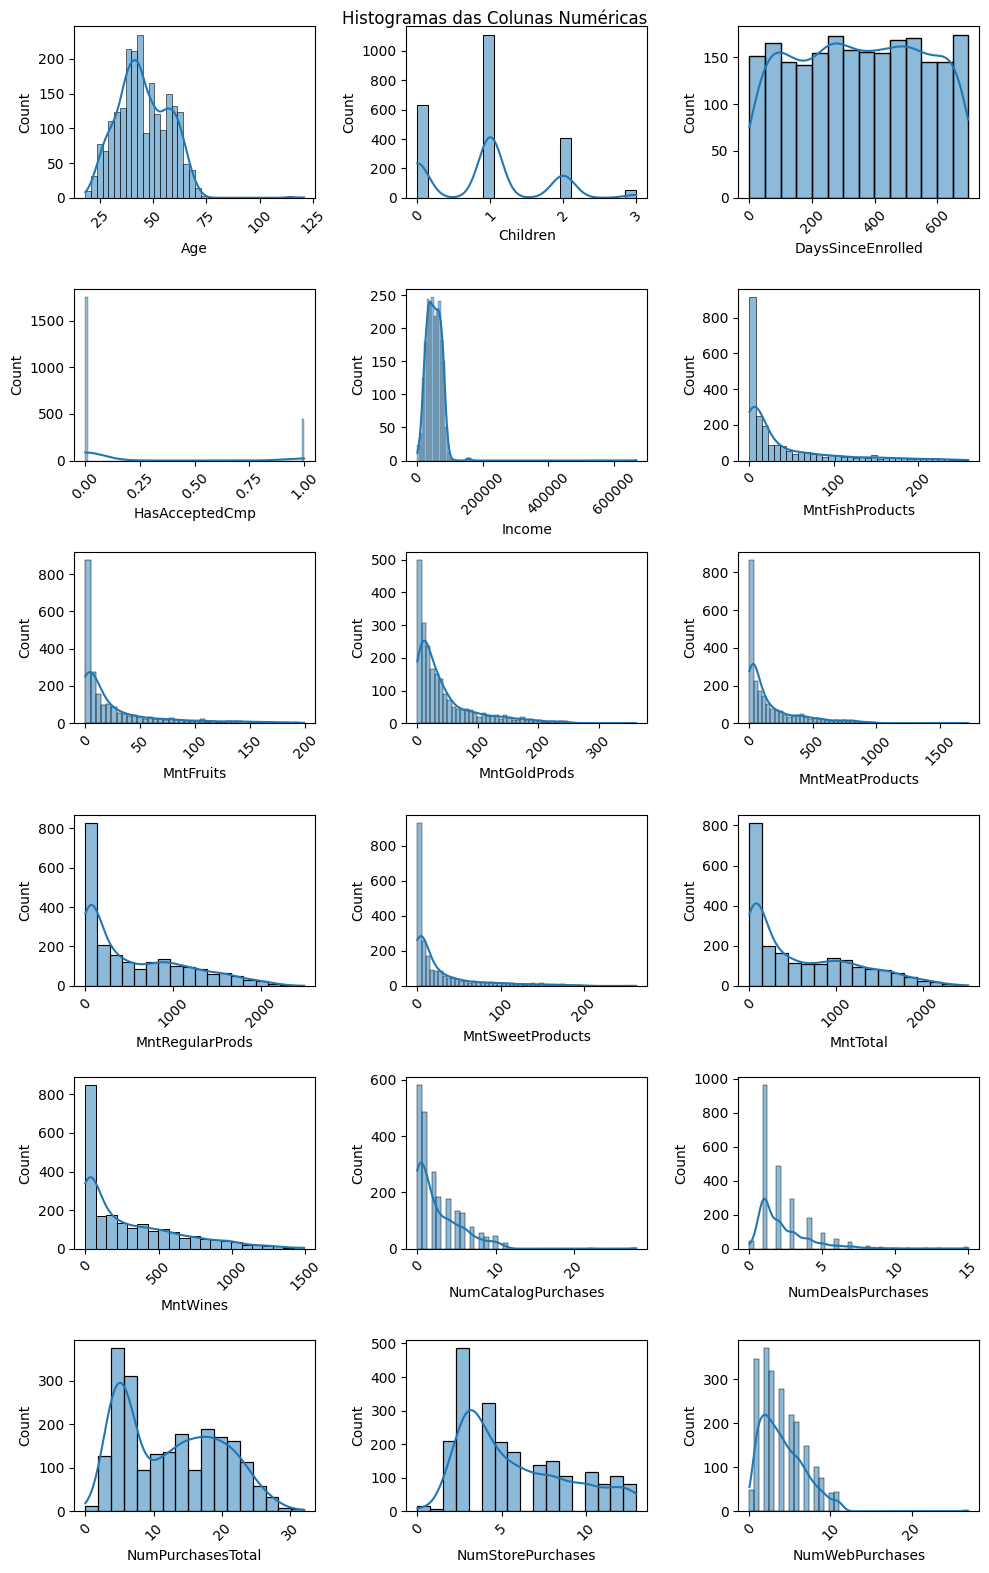

In [64]:
# Análise de histograma com atributos numéricos

fig, axs = plt.subplots(6, 3, figsize=(10, 16))

fig.suptitle("Histogramas das Colunas Numéricas")

for ax, column in zip(axs.flatten(), numeric_columns):

    sns.histplot(
        df,
        x=column,
        kde=True,
        ax=ax,
    )

    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

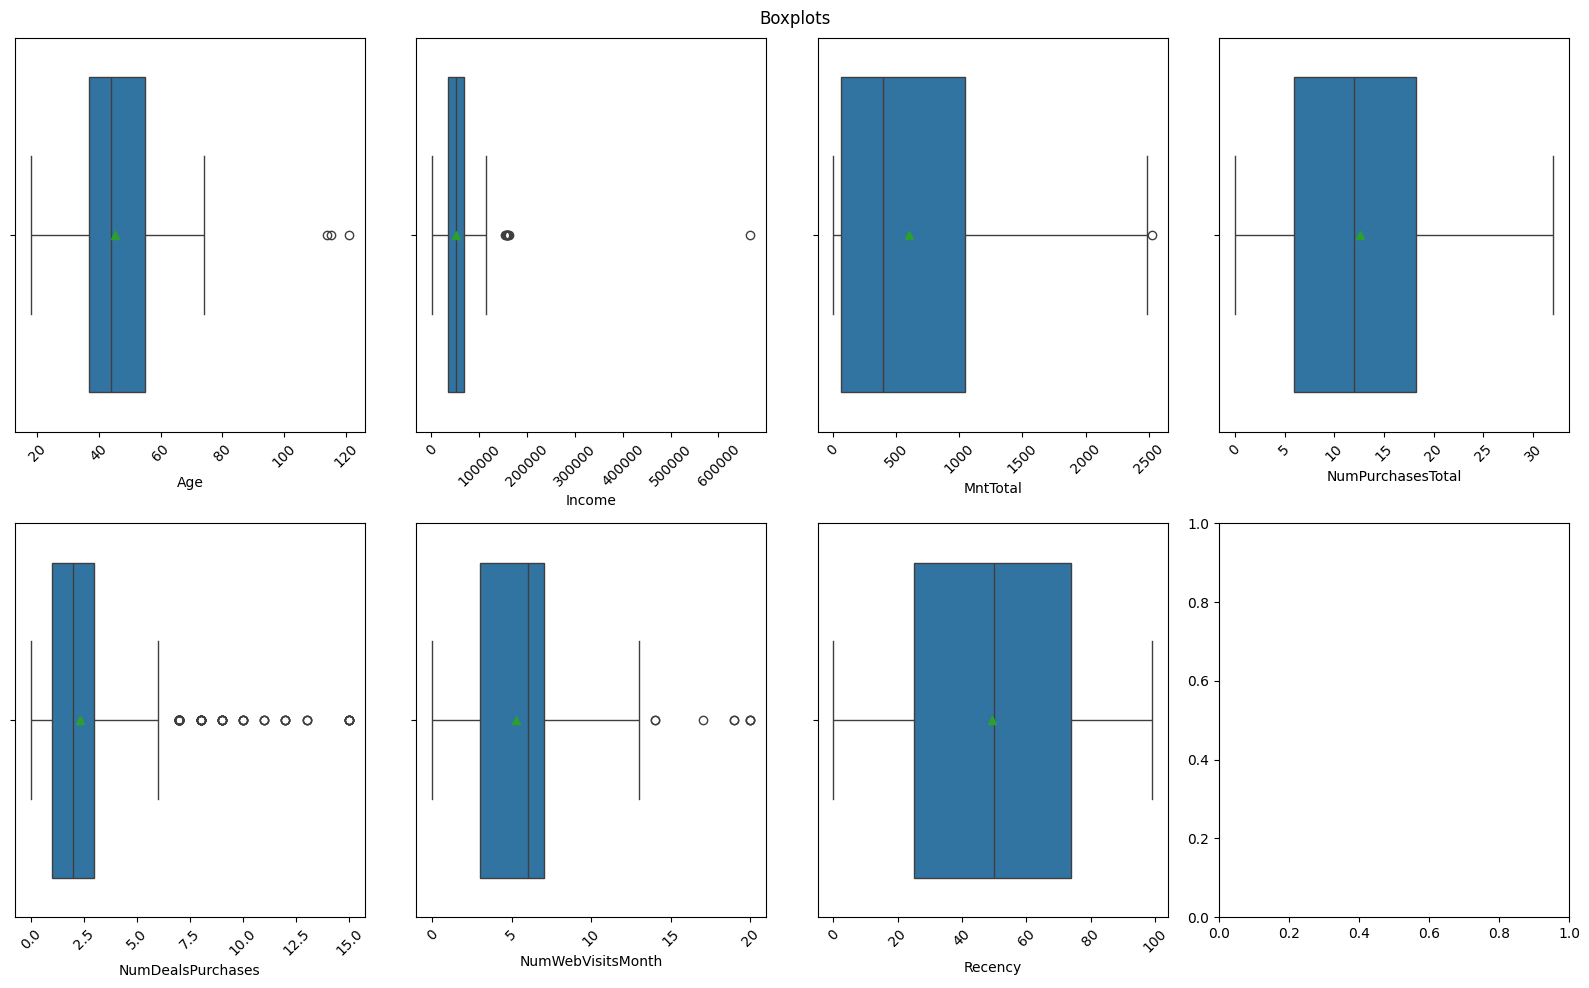

In [65]:
# Análise de boxplots com atributos numéricos

context_numeric_columns = [
    "Age",
    "Income",
    "MntTotal",
    "NumPurchasesTotal",
    "NumDealsPurchases",
    "NumWebVisitsMonth",
    "Recency"
]

fig, axs = plt.subplots(2, 4, figsize=(16, 10))

fig.suptitle("Boxplots")

for ax, column in zip(axs.flatten(), context_numeric_columns):

    sns.boxplot(
        df,
        x=column,
        showmeans=True,
        ax=ax,
    )

    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Outliers próximos aos quartis e com "comportamento linear" não são tão problemáticos, pois não indicam ruído ao atributo.

Porém, outliers altamente discrepantes e com poucas ocorrências podem indicar ruído, e devem ser analisados com mais detalhes.

Nessa base, podem ser apontados nessa categoria:

- `Age`, para valores superiores a 100
- `Income`, para valores superiores a 60000
- `NumWebVisitsMonth`, para valores superiores a 15

In [66]:
# Analisando os registros com valores outliers em Idade
inspect_outliers(df, "Age")

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,DaysSinceEnrolled,YearsSinceEnrolled,Age,MntTotal,MntRegularProds,Children,hasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumPurchasesTotal
189,2n Cycle,Divorced,36640.0,1,0,99,15,6,8,7,4,25,1,2,1,2,5,0,0,0,0,0,1,0,276,0,114,65,40,1,1,0,0,5
235,2n Cycle,Single,60182.0,0,1,23,8,0,5,7,0,2,1,1,0,2,4,0,0,0,0,0,0,0,43,0,121,22,20,1,1,0,0,3
334,PhD,Together,83532.0,0,0,36,755,144,562,104,64,224,1,4,6,4,1,0,0,1,0,0,0,0,276,0,115,1853,1629,0,0,1,1,14


Há poucas ocorrências desses valores, que são muitos discrepantes em relação aos demais dados. E como todos os registros são da classe 0 em `Response`, é prudente removê-los.

In [67]:
# Removendo os outliers de Age

remove_indexes = inspect_outliers(df, "Age").index

df = df[~(df["Age"].isin(remove_indexes))].reset_index(drop=True)

In [68]:
# Analisando os registros com valores outliers em Income
inspect_outliers(df, "Income")

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,DaysSinceEnrolled,YearsSinceEnrolled,Age,MntTotal,MntRegularProds,Children,hasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumPurchasesTotal
161,PhD,Married,157243.0,0,1,98,20,2,1582,1,2,1,15,0,22,0,0,0,0,0,0,0,0,0,120,0,41,1608,1607,1,1,0,0,22
607,PhD,Together,162397.0,1,1,31,85,1,16,2,1,2,0,0,0,1,1,0,0,0,0,0,0,0,391,1,38,107,105,2,1,0,0,1
645,Graduation,Divorced,153924.0,0,0,81,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,142,0,39,6,5,0,0,0,0,0
677,PhD,Married,160803.0,0,0,21,55,16,1622,17,3,4,15,0,28,1,0,0,0,0,0,0,0,0,694,1,32,1717,1713,0,0,0,0,29
1277,Master,Together,157733.0,1,0,37,39,1,9,2,0,8,0,1,0,1,1,0,0,0,0,0,0,0,390,1,43,59,51,1,1,0,0,2
1621,Graduation,Together,157146.0,0,0,13,1,0,1725,2,1,1,0,0,28,0,1,0,0,0,0,0,0,0,426,1,37,1730,1729,0,0,0,0,28
2095,PhD,Married,156924.0,0,0,85,2,1,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,304,0,65,8,7,0,0,0,0,0
2193,Graduation,Together,666666.0,1,0,23,9,14,18,8,1,12,4,3,1,3,6,0,0,0,0,0,0,0,392,1,37,62,50,1,1,0,0,7


Na coluna `Income`, existem outliers que não são tão discrepantes e que aparecem mais vezes, o que reduz a possibilidade deles serem errôneos. Porém, isso não se aplica ao registro com valor 666666, que deve ser removido.

In [69]:
# Removendo os outliers discrepantes de Income

df = df[df["Income"] < 600_000].reset_index(drop=True)
df["Income"].max()

np.float64(162397.0)

In [70]:
# Analisando os registros com valores outliers em NumWebVisitsMonth
inspect_outliers(df, "NumWebVisitsMonth")

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,DaysSinceEnrolled,YearsSinceEnrolled,Age,MntTotal,MntRegularProds,Children,hasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumPurchasesTotal
8,PhD,Together,5648.0,1,1,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,0,108,0,64,49,36,2,1,1,1,1
763,PhD,Together,6835.0,0,1,76,107,2,12,2,2,12,0,0,0,1,20,0,0,0,0,0,0,0,568,1,57,137,125,1,1,0,0,1
967,Graduation,Divorced,4861.0,0,0,20,2,1,1,1,0,1,0,0,0,0,14,0,0,0,0,0,0,0,7,0,49,6,5,0,0,0,0,0
1027,Graduation,Single,8028.0,0,0,62,73,18,66,7,12,2,15,0,1,0,19,0,0,0,0,0,0,0,649,1,23,178,176,0,0,0,0,1
1224,Graduation,Divorced,1730.0,0,0,65,1,1,3,1,1,1,15,0,0,0,20,0,0,0,0,0,0,0,42,0,43,8,7,0,0,0,0,0
1305,Master,Single,6560.0,0,0,2,67,11,26,4,3,262,0,1,0,1,17,0,0,0,0,0,0,0,199,0,32,373,111,0,0,0,0,2
1497,Graduation,Single,3502.0,1,0,56,2,1,1,0,0,1,0,0,0,0,14,0,0,0,0,0,0,0,442,1,41,5,4,1,1,0,0,0
1810,PhD,Married,4023.0,1,1,29,5,0,1,1,1,1,15,0,0,0,19,0,0,0,0,0,0,0,6,0,51,9,8,2,1,0,0,0


Não parece haver grandes discrepâncias entre os outliers de `NumWebVisitsMonth`. Logo, não irei removê-los.

In [71]:
len(nominal_categoric_columns)

9

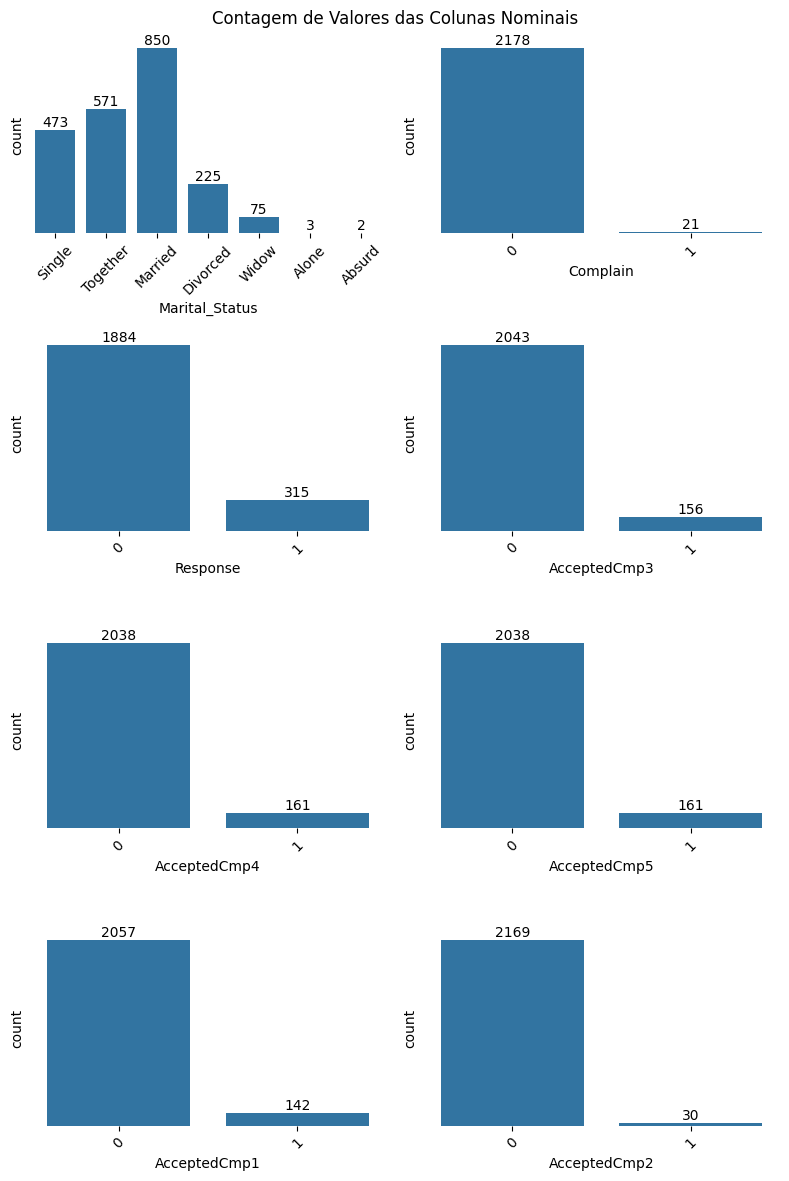

In [72]:
# Contagem de valores das colunas categóricas nominais

fig, axs = plt.subplots(4, 2, figsize=(8, 12))

fig.suptitle("Contagem de Valores das Colunas Nominais")

for ax, column in zip(axs.flatten(), nominal_categoric_columns):

    sns.countplot(
        df,
        x=column,
        ax=ax,
    )

    ax.tick_params(axis='x', rotation=45)
    ax.set_frame_on(False)

    ax.set_yticks([])

    for container in ax.containers:

        ax.bar_label(container)

plt.tight_layout()
plt.show()

Em `Marital_Status`, existem dois valores com poucas ocorrências e com pouca representatividade a base, que são 'Alone' e 'Absurd'. Durante a análise bivariata, será tomada a decisão se os registros com elas serão removidos ou se elas se juntarão a outras categorias.

As colunas `Complain` e `AcceptedCmp2` possuem uma predominância de valor 0. Além disso, elas são colunas binárias, o que impossibilita qualquer tipo de agregação. Logo, elas provavelmente serão removidas.

In [73]:
len(ordinal_categoric_columns)

4

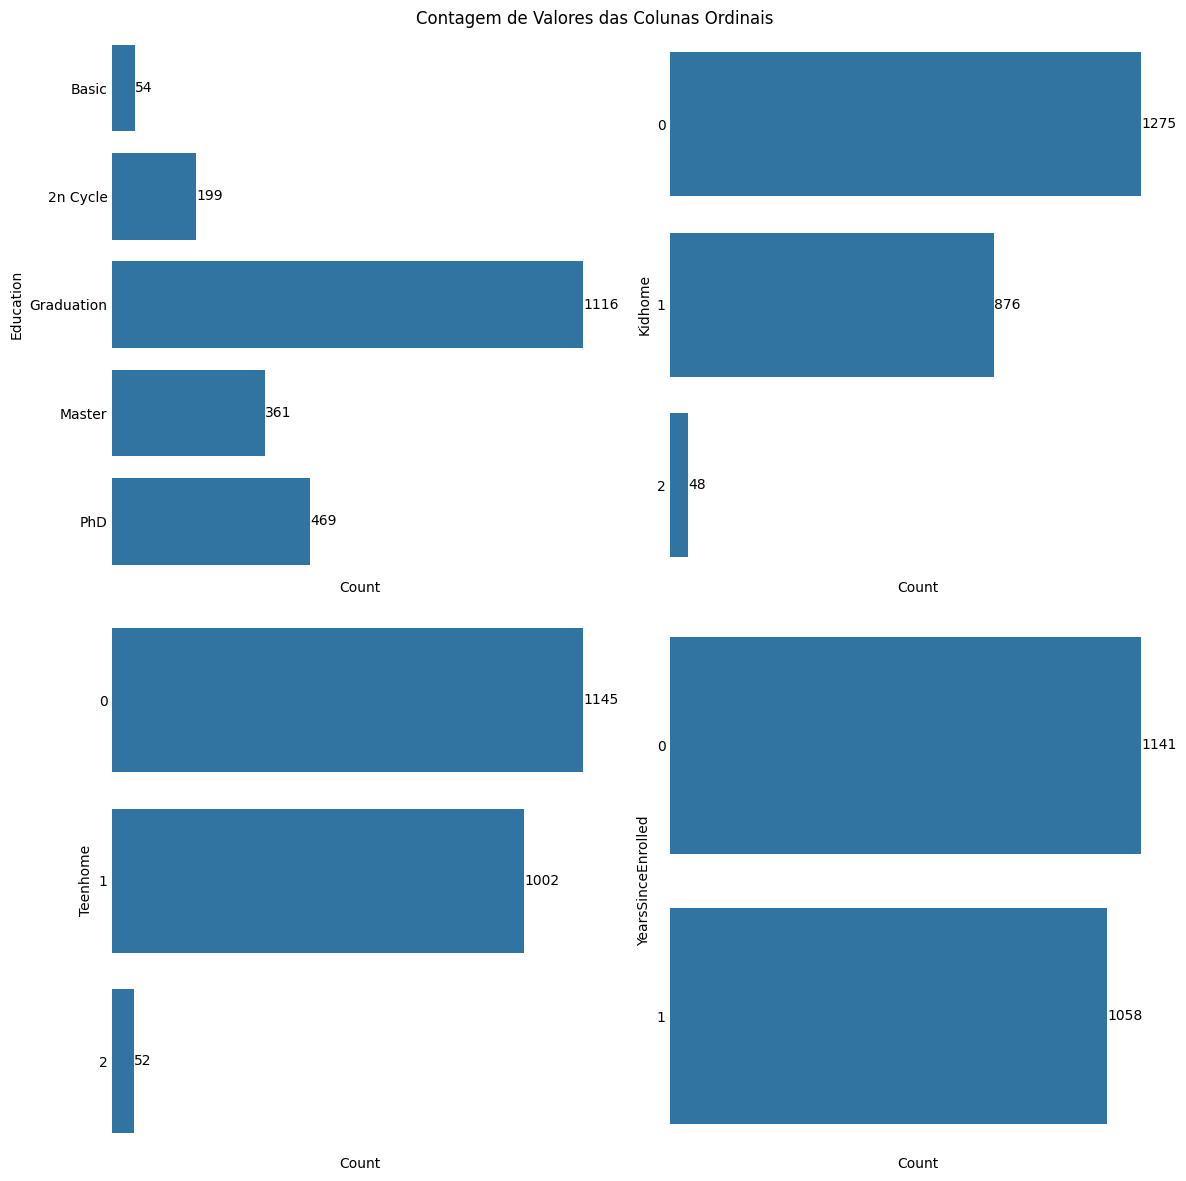

In [74]:
# Contagem de valores das colunas categóricas ordinais

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

fig.suptitle("Contagem de Valores das Colunas Ordinais")

for ax, column, categories_order in zip(axs.flatten(), ordinal_categoric_columns, categories_orders):

    count_data = pd.Categorical(
        df[column], 
        categories=categories_order, 
        ordered=True
        ).value_counts().sort_index()

    sns.barplot(
        y=count_data.index,
        x=count_data.values,
        ax=ax,
        orient='h',
    )

    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', size=0)
    ax.set_xticks([])
    
    ax.set_frame_on(False)

    ax.set_xlabel("Count")
    ax.set_ylabel(column)

    for container in ax.containers:

        ax.bar_label(container)

plt.tight_layout()
plt.show()

As três colunas de natureza ordinal (`Education`, `Kidhome` e `Teenhome`) possuem valores com baixíssima representatividade, que são 'Basic', 2 e 2, respectivamente. Na análise bivariada será decidido o que fazer com os registros com esses valores.

É possível gerar um atributo derivado da coluna `Age` que inclua grupos de idade (`AgeGroup`), através de discretização. Talvez não agregará muito valor ao algoritmo de classificação, mas pode facilitar algumas análises da base com atributos numéricos.

Os grupos serão definidos por
- Jovens Adultos: de 18 a 30
- Adultos: de 31 a 45
- Adultos Seniores: 46 a 60
- Idoso: 61 para cima

In [75]:
# Gerando o atributo derivado AgeGroup

bins = [18, 30, 45, 60, df["Age"].max()]
labels = ["18-30", "31-45", "46-60", "61+"]

df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=bins,
    labels=labels,
    include_lowest=True
)
df["AgeGroup"].value_counts()

AgeGroup
31-45    955
46-60    724
61+      267
18-30    253
Name: count, dtype: int64

Será avaliado a coluna `Marital_Status`. Como mencionado, os valores 'Alone' e 'Absurd' possuem pouca representatividade na base. Além disso, é possível reduzir um pouco a cardinalidade desse atributo.

Uma estratégia seria categorizar essa coluna em apenas dois valores: 'Single', para pessoas sozinhas, e 'Pattern' para pessoas que possuem parceiros. No primeiro, se encaixam os valores 'Single', 'Divorced', 'Widow' e 'Alone', e no segundo se encaixam os valores 'Together' e 'Married'. Como o 'Absurd' possui pouquíssimas ocorrências, e não tenho certeza em qual categoria ele entraria, acho adequado removê-lo da base.

In [76]:
# Removendo os registros com 'Absurd' em Marital_Status
df = df[df["Marital_Status"] != "Absurd"]
df["Marital_Status"].value_counts()

Marital_Status
Married     850
Together    571
Single      473
Divorced    225
Widow        75
Alone         3
Name: count, dtype: int64

In [77]:
# Agregando os valores de Marital_Status em 'Single' e 'Partner'
marital_new_categories = {
    value: "Partner" if value in ["Together", "Married"] else "Single" for value in df["Marital_Status"].unique()
}

df["Marital_Status"] = df["Marital_Status"].map(marital_new_categories)
df["Marital_Status"].value_counts()

Marital_Status
Partner    1421
Single      776
Name: count, dtype: int64

In [78]:
# Salvando as mudanças
df.to_parquet(DADOS_TRATADOS, index=False)